<a href="https://colab.research.google.com/github/agpascoe/NN_experiments/blob/main/Pytorch/GAN_MNIST_Trainned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [17]:
# HyperParameters
EPOCHS = 400
INFO_STEP = 4800
ZDIM = 128
LR = 1e-5
BATCHSIZE = 125
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATALOADER = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=BATCHSIZE)

from torch.nn.modules.activation import ReLU
#defining two models, Generator and Discriinator

def generatorBlock(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.BatchNorm1d(output),
      nn.ReLU(inplace=True) #optimize memory because makes the operation directly
  )

class generatorClass(nn.Module):
  def __init__(self, zDim, hiddenDim, outputDim):
    super().__init__()
    self.gen = nn.Sequential(
        generatorBlock(zDim, hiddenDim),
        generatorBlock(hiddenDim, 2*hiddenDim),
        generatorBlock(2*hiddenDim, 4*hiddenDim),
        generatorBlock(4*hiddenDim, 8*hiddenDim),
        nn.Linear(8*hiddenDim, outputDim),
        nn.Sigmoid(),
    )
    self.optimizer = torch.optim.Adam(self.parameters(), lr = LR)
  
  def forward(self, noise):
    return self.gen(noise)


def discriminatorBlock(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.LeakyReLU(0.2, inplace=True) #The size of the slope is 0.2
  )

class discriminatorClass(nn.Module):
  def __init__(self,inputDim):
    super().__init__()
    self.disc = nn.Sequential(
        discriminatorBlock(inputDim, int(inputDim/2)),
        discriminatorBlock(int(inputDim/2), int(inputDim/4)),
        discriminatorBlock(int(inputDim/4), int(inputDim/8)),
        nn.Linear(int(inputDim/8),1)
    )
    self.optimizer = torch.optim.Adam(self.parameters(), lr = LR)


  def forward(self, image):
    return self.disc(image)

class ganClass(nn.Module):
  def __init__(self, zDim, hiddenGenDim, inputDiscDim):
    super().__init__()
    self.generator = generatorClass(zDim, hiddenGenDim, inputDiscDim)
    self.discriminator = discriminatorClass(inputDiscDim)
    self.lossFunction = nn.BCEWithLogitsLoss()

  def forward(self, noise):
    return self.discriminator(self.generator(noise))

  def lossGenCalculation(self, number, zDim):
    preds = self.discriminator(self.generator(noiseGenerator(number, zDim)))
    return self.lossFunction(preds, torch.ones_like(preds).to(DEVICE))
  
  def lossDiscCalculation(self, number, zDim, real):
    discFake = self.discriminator(self.generator(noiseGenerator(number, zDim)).detach())
    discFakeLoss = self.lossFunction(discFake, torch.zeros_like(discFake).to(DEVICE))
    discReal = self.discriminator(real)
    discRealLoss = self.lossFunction(discReal, torch.ones_like(discReal).to(DEVICE))
    return (discFakeLoss+discRealLoss)/2

  def fit(self, zDim, dataloader=DATALOADER, epochs = EPOCHS):
    
    #Setup main parameters
    currentStep = 0
    currentBatchSize = 0
    meanGeneratorLoss = 0
    mGL = []
    mDL = []
    meanDiscrtiminatorLoss = 0

    
    for epoch in tqdm(range(epochs)):
      for real, _ in dataloader:
        #trainning discriminator
        real=real.to(DEVICE)
        self.discriminator.optimizer.zero_grad()
        currentBatchSize = len(real)
        real = real.view(currentBatchSize, -1) #resizes to 128 x xx for example
        discLoss = self.lossDiscCalculation(currentBatchSize, zDim, real)
        discLoss.backward(retain_graph=True)
        self.discriminator.optimizer.step()


        #trainning generator
        self.generator.optimizer.zero_grad()
        genLoss = self.lossGenCalculation(currentBatchSize,zDim)
        genLoss.backward(retain_graph=True)
        self.generator.optimizer.step()

        meanDiscrtiminatorLoss+= discLoss.item() / INFO_STEP
        meanGeneratorLoss += genLoss.item() / INFO_STEP
        mDL.append(discLoss.item())
        mGL.append(genLoss.item())

        if (currentStep+1) % INFO_STEP == 0 or currentStep == 10:
          fake = self.generator(noiseGenerator(currentBatchSize, zDim))
          show_images(fake)
          print(f'{epoch}, step: {currentStep} from {epochs*len(dataloader)}, MeanDiscLoss: {meanDiscrtiminatorLoss}, GenDiscLoss: {meanGeneratorLoss}')
          plt.plot(mDL, label="DiscLoss")
          plt.plot(mGL, label = "GenLoss")
          plt.legend()
          plt.show()
          meanGeneratorLoss, meanDiscrtiminatorLoss = 0,0
        currentStep+= 1  

    return(mDL, mGL)

#this is a visualization function
def show_images(input, channel=1, size=(28,28), sizegrid=6):
  #The imput is a vector of (samples, size), that is a comprossed nxn image (784 in this example)
  data = input.detach().cpu().view(-1, channel, *size) # move from (samples,nxn) vector to a (samples, 1, n, n) and move it to a CPU
  grid = make_grid(tensor=data[:sizegrid**2], nrow=sizegrid, padding=False).permute(1,2,0) # create a sizegrid x sizegrid grid ready for being plot (permute)
 
#  print(data.shape, grid.shape)
  plt.imshow(grid)
  plt.show()


In [18]:
model = torch.load('./drive/MyDrive/gan_2_0.pt')
model.eval()

ganClass(
  (generator): generatorClass(
    (gen): Sequential(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (3): Sequential(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (4): Linear(in_features=1024, out_fe

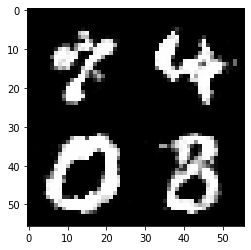

In [59]:
fake = model.generator(torch.randn(4, 128).to(DEVICE))
show_images(fake, sizegrid=2)